# Language Translation

We will use an Encoder_Decoder architecture for our language translation model from English to German.

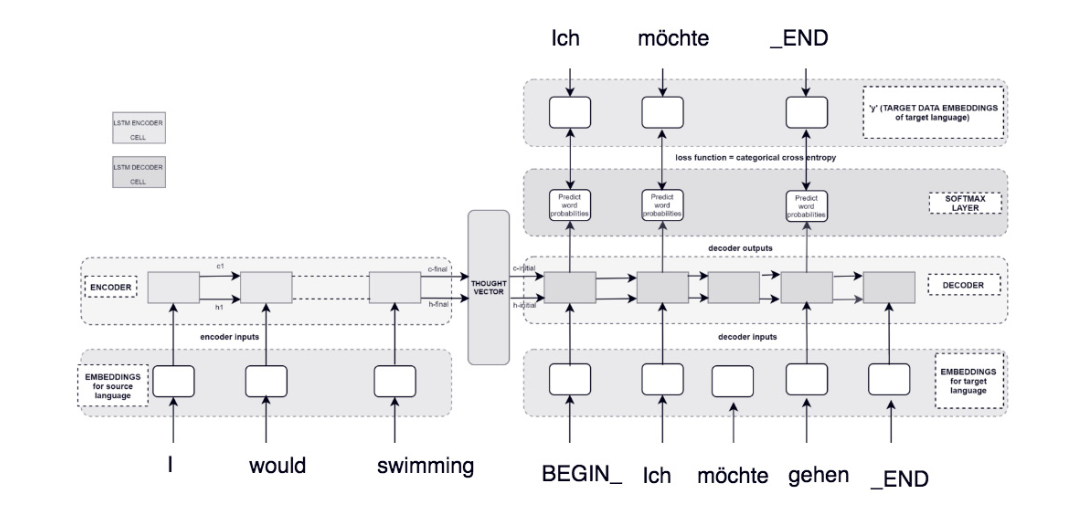

In [32]:
from IPython.display import Image
Image('./images/Encoder_Decoder.png')

Above is the architecture we will be using. The training input (English) data first will be embedded, then fed to the Encoder. The output of the Encoder is a thought vector that carries the last state and cell output. These outputs will then be fed as input to the Decoder. In addition, the Decoder will also be fed the target input (German) data. The final output is the translation from English to German. This is a seq2seq model. The goal is to predict the next word using the previous words.

## Data Loading

In [14]:
# Loading data
import os
import re
import numpy as np

# Model building

from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.models import Model

In [3]:
with open("./data/deu.txt", 'r', encoding='utf-8') as f:
    lines = f.read().split('\n')
    num_samples = 20000 # Using only 20000 pairs
    lines_to_use = lines[: min(num_samples, len(lines) - 1)]

display(lines_to_use)

['Hi.\tHallo!',
 'Hi.\tGrüß Gott!',
 'Run!\tLauf!',
 'Wow!\tPotzdonner!',
 'Wow!\tDonnerwetter!',
 'Fire!\tFeuer!',
 'Help!\tHilfe!',
 'Help!\tZu Hülf!',
 'Stop!\tStopp!',
 'Wait!\tWarte!',
 'Go on.\tMach weiter.',
 'Hello!\tHallo!',
 'I ran.\tIch rannte.',
 'I see.\tIch verstehe.',
 'I see.\tAha.',
 'I try.\tIch probiere es.',
 'I won!\tIch hab gewonnen!',
 'I won!\tIch habe gewonnen!',
 'Smile.\tLächeln!',
 'Cheers!\tZum Wohl!',
 'Freeze!\tKeine Bewegung!',
 'Freeze!\tStehenbleiben!',
 'Got it?\tKapiert?',
 'Got it?\tVerstanden?',
 'Got it?\tEinverstanden?',
 'He ran.\tEr rannte.',
 'He ran.\tEr lief.',
 'Hop in.\tMach mit!',
 'Hug me.\tDrück mich!',
 'Hug me.\tNimm mich in den Arm!',
 'Hug me.\tUmarme mich!',
 'I fell.\tIch fiel.',
 'I fell.\tIch fiel hin.',
 'I fell.\tIch stürzte.',
 'I fell.\tIch bin hingefallen.',
 'I fell.\tIch bin gestürzt.',
 'I know.\tIch weiß.',
 'I lied.\tIch habe gelogen.',
 'I lost.\tIch habe verloren.',
 'I paid.\tIch habe bezahlt.',
 'I paid.\tIch zahlt

Each line contains an English sentence and its German equivalent followed by an escape character '\t'. Now let's append 'BEGIN_' and '_END' tokens to each German sentence so the model knows when the sentences start and end.

In [4]:
# Text corpus
input_texts = []
target_texts = []

# Unique words in input and target data
input_words = set()
target_words = set()

for line in lines_to_use:
    input_text, target_text = line.split('\t')
    target_text = 'BEGIN_ ' + target_text + ' _END'
    input_texts.append(input_text)
    target_texts.append(target_text)
    for word in input_text.split():
        if word not in input_words:
            input_words.add(word)
    for word in target_text.split():
        if word not in target_words:
            target_words.add(word)

In [5]:
print('English words:')
display(input_texts[0:5])
print('==='*30)
print('German counterparts:')
display(target_texts[0:5])

English words:


['Hi.', 'Hi.', 'Run!', 'Wow!', 'Wow!']

German counterparts:


['BEGIN_ Hallo! _END',
 'BEGIN_ Grüß Gott! _END',
 'BEGIN_ Lauf! _END',
 'BEGIN_ Potzdonner! _END',
 'BEGIN_ Donnerwetter! _END']

In [6]:
max_input_seq_length = max([len(i.split()) for i in input_texts])
max_target_seq_length = max([len(i.split()) for i in target_texts])

print('The maximum sentence length of input texts:')
print(max_input_seq_length)
print('The maximum sentence length of target texts:')
print(max_target_seq_length)


The maximum sentence length of input texts:
6
The maximum sentence length of target texts:
12


The maximum length of a sentence in the input data is 6 word-long. While that of the target data is 12 word-long.

In [7]:
# Reorder input and output text corpus 
input_words = sorted(list(input_words))
target_words = sorted(list(target_words))

# The number of unique words in texts corpus
num_encoder_tokens = len(input_words)
num_decoder_tokens = len(target_words)

print('Reordered input texts:')
display(input_words[0:5])
print('Reordered target texts:')
display(target_words[0:5])


Reordered input texts:


['"Look,"', '"aah."', '$10.', '$10.00.', '$100.']

Reordered target texts:


['"Schau!"', '$.', '%', "'ne", '.']

## Vectorize Texts

Since our model doesn't understand texts, we'll assign each unique word with a unique integer

In [8]:
# Assigning a unique integer to each unique word from each text corpus to feed into the model
input_token_index = dict(
[(word, i) for i, word in enumerate(input_words)])
target_token_index = dict(
[(word, i) for i, word in enumerate(target_words)])

In [9]:
out = dict(list(input_token_index.items())[0:5])
print('first five values in indexed input:', str(out))

first five values in indexed input: {'"Look,"': 0, '"aah."': 1, '$10.': 2, '$10.00.': 3, '$100.': 4}


In [37]:
encoder_input_data = np.zeros(
    (len(input_texts), max_input_seq_length),
    dtype='float32')
print('encoder input data shape:', encoder_input_data.shape)
decoder_input_data = np.zeros(
    (len(target_texts), max_target_seq_length),
    dtype='float32')
print('decoder input data shape:', decoder_input_data.shape)
decoder_target_data = np.zeros(
    (len(target_texts), max_target_seq_length, num_decoder_tokens),
    dtype='float32')
print('decoder target data shape:', decoder_target_data.shape)


encoder input data shape: (20000, 6)
decoder input data shape: (20000, 12)
decoder target data shape: (20000, 12, 9161)


The encoder input data has 20k rows and 6 columns correspond to 20k English sentences and the maximum of a sentence length. The same applies to the decode input data. However, the decoder target data has an extra dimension of 9161, which corresponds to 9161 unique tokens in the target words.

In [38]:
for i, (input_text, target_text) in enumerate(zip(input_texts, target_texts)):
    for t, word in enumerate(input_text.split()):
        encoder_input_data[i, t] = input_token_index[word]
    for t, word in enumerate(target_text.split()):
        decoder_input_data[i, t] = target_token_index[word]
        if t > 0:
            # decoder_target_data is ahead of decoder_input_data by one timestep
            decoder_target_data[i, t - 1, target_token_index[word]] = 1.

In [39]:
encoder_input_data[0:5]

array([[329.,   0.,   0.,   0.,   0.,   0.],
       [329.,   0.,   0.,   0.,   0.,   0.],
       [550.,   0.,   0.,   0.,   0.,   0.],
       [751.,   0.,   0.,   0.,   0.,   0.],
       [751.,   0.,   0.,   0.,   0.,   0.]], dtype=float32)

We encode each sentence with integers and pad 0s at the end to ensure fixed input sequence length

In [15]:
print('The first five English sentences:',input_texts[0:5])
print('The corresponding integer index:')
indices = [input_token_index[x] for x in input_texts[0:5]]
display(indices)

The first five English sentences: ['Hi.', 'Hi.', 'Run!', 'Wow!', 'Wow!']
The corresponding integer index:


[329, 329, 550, 751, 751]

The first five examples in encoder_input_data corresponds to the first five sentences in the input texts. The same applies to the decoder_input_data.

## LSTM -Encoder

In [23]:
embedding_size = 50
encoder_inputs = Input(shape=(None,))
encoder_after_embedding =  Embedding(
    num_encoder_tokens, embedding_size)(encoder_inputs)
encoder_lstm = LSTM(50, return_state=True)
_, state_h, state_c = encoder_lstm(encoder_after_embedding)
encoder_states = [state_h, state_c]

In [27]:
num_encoder_tokens

5768

## LSTM-Decoder

In [24]:
decoder_inputs = Input(shape=(None,))
decoder_after_embedding = Embedding(
    num_decoder_tokens, embedding_size)(decoder_inputs)
decoder_lstm = LSTM(50, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(decoder_after_embedding,
                                     initial_state=encoder_states)
decoder_dense = Dense(num_decoder_tokens, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

## LSTM Model

In [44]:
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='rmsprop', 
              loss='categorical_crossentropy', 
              metrics=['acc'])

In [45]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            (None, None)         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, None, 50)     288400      input_4[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, None, 50)     458050      input_5[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM

In [46]:
history = model.fit([encoder_input_data, decoder_input_data], decoder_target_data,
          batch_size=128,
          epochs=20,
          validation_split=0.05)

Train on 19000 samples, validate on 1000 samples
Epoch 1/20
19000/19000 [==============================] - 50s 3ms/sample - loss: 1.8572 - acc: 0.1163 - val_loss: 2.0931 - val_acc: 0.1348
Epoch 2/20
19000/19000 [==============================] - 20s 1ms/sample - loss: 1.7334 - acc: 0.1376 - val_loss: 1.9874 - val_acc: 0.1366
Epoch 3/20
19000/19000 [==============================] - 24s 1ms/sample - loss: 1.6415 - acc: 0.1474 - val_loss: 1.9264 - val_acc: 0.1409
Epoch 4/20
19000/19000 [==============================] - 18s 961us/sample - loss: 1.5780 - acc: 0.1549 - val_loss: 1.8975 - val_acc: 0.1479
Epoch 5/20
19000/19000 [==============================] - 19s 976us/sample - loss: 1.5298 - acc: 0.1612 - val_loss: 1.8686 - val_acc: 0.1538
Epoch 6/20
19000/19000 [==============================] - 19s 998us/sample - loss: 1.4896 - acc: 0.1655 - val_loss: 1.8328 - val_acc: 0.1575
Epoch 7/20
19000/19000 [==============================] - 19s 991us/sample - loss: 1.4549 - acc: 0.1697 - val_l

Text(0, 0.5, 'Accuracy')

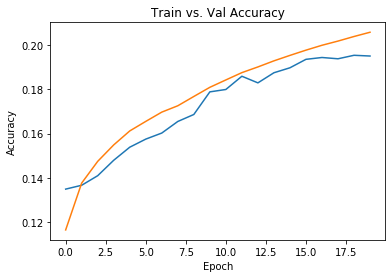

In [55]:
import matplotlib.pyplot as plt
%matplotlib inline
train_acc = history.history['acc']
train_loss = history.history['loss']
val_acc = history.history['val_acc']
val_loss = history.history['val_loss']

plt.figure()
x = range(0, len(val_acc))
plt.plot(x,val_acc)
plt.plot(x,train_acc)
plt.title('Train vs. Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

As shown above, the accuracy for the lstm model is not very good as it fluctuates between 18 - 20%.